# Generate main figures

This notebook generates the main figures of the article "The Structure and Statistics of Language jointly shape Cross-frequency Dynamics during Spoken Language Comprehension", H. Weissbart & AE. Martin.

The following code rely on the Source Data accompnaying the article. The Source Data is available from the the figshare repository: https://doi.org/10.6084/m9.figshare.16668207

## Content

1. [Figure 2](#Figure-2)
2. [Figure 3](#Figure-3)
3. [Figure 4](#Figure-4)
4. [Figure 5](#Figure-5)

__Note__

> - Figure 1 is a schematic representation of the analysis pipeline and is not generated by the present notebook.
> - Figure 6 of the article is generated with simulations and is not included in the present notebook, however we supply another notebook to generate the simulations and the accompanying figure, see end of `example_PAC_regresed.ipynb`.

## Libraries

Libraries and parameters used in the notebook. We will also add the code from `audiobook` to the Python path to be able to use the functions from the package.

We assume that all required libraries are installed (this include the `pyeeg` package).

In [20]:
# Path to Source Data (available from the Figshare repository at https://doi.org/10.6084/m9.figshare.12216163)
source_data_path = 'D:\\HugoWeissbart_DCCN2020\\Data_Figshare_NatComm2024\\Source Data'

# Processed MEG data from that same Figshare repository can be stored in the ../data/meg/ folder, otherwise, please rewrite DATA_PATH (see below)

In [64]:
import sys
if '../' not in sys.path:
    sys.path.append('../') # this is to add the audiobook folder to the python path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from audiobook.utils import extract_story_parts_data, STORIES, DATA_PATH, subjects, STIM_PATH
# If the data are not in the default location (`../data/meg/processed`), please specify the path here
DATA_PATH = 'D:\\HugoWeissbart_DCCN2020\\Data_Figshare_NatComm2024'
from audiobook.features import get_wordlevel_aligned
import pandas as pd 
from pyeeg.models import TRFEstimator
from itertools import chain

# Figure parameters
plt.style.use('default')
plt.rcParams['figure.figsize'] = [7.2, 5.4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'sans'
# plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.size'] = 7
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.dpi'] = 300


## Colors
featsets = [['wordonsets'],
            ['wordonsets', 'depth', 'close'],
            ['wordonsets', 'surprisal', 'entropy'],
            ['wordonsets', 'surprisal', 'entropy', 'depth', 'close']]

colors = {'wordonsets': (0.3,)*3}
for k in featsets:
    key = '_'.join(k)
    is_predict = any([f in key for f in ['surprisal', 'wordfrequency']])
    is_syntax = any([f in key for f in ['open', 'depth', 'close']])
    if is_predict and not is_syntax:
        if 'entropy' in key:
            colors[key] = sns.blend_palette(['purple', 'seagreen', 'orange'], n_colors=5)[2]
        else:
            colors[key] = sns.blend_palette(['purple', 'seagreen', 'orange'], n_colors=5)[3]
    if is_syntax and not is_predict:
        colors[key] = sns.blend_palette(['purple', 'seagreen', 'orange'], n_colors=5)[0]
    if is_syntax and is_predict:
        colors[key] = sns.blend_palette(['purple', 'seagreen', 'orange'], n_colors=5)[-1]


colors = {'wordonsets': (0.3,)*3}
for k in featsets:
    key = '_'.join(k)
    is_predict = any([f in key for f in ['surprisal', 'wordfrequency']])
    is_syntax = any([f in key for f in ['open', 'depth', 'close']])
    if is_predict and not is_syntax:
        if 'entropy' in key:
            colors[key] = sns.blend_palette(['#7A4B9B', '#2AAD9D', 'orange'], n_colors=5)[2]
        else:
            colors[key] = sns.blend_palette(['#7A4B9B', '#2AAD9D', 'orange'], n_colors=5)[3]
    if is_syntax and not is_predict:
        colors[key] = sns.blend_palette(['#7A4B9B', '#2AAD9D', 'orange'], n_colors=5)[0]
    if is_syntax and is_predict:
        colors[key] = sns.blend_palette(['#7A4B9B', '#2AAD9D', 'orange'], n_colors=5)[-1]

paper_fontsizes = {
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 7
}

## Figure 2

This figures presents the summary of stimulus statistics and MEG spectra:

- Power spectra of MEG
- power spectra of audio fr vs nl
- coherence
- ITPC and Power modulation

In [13]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
norm = mcolors.LogNorm(vmin=0.01, vmax=10)
norm = mcolors.Normalize(vmin=0.01, vmax=10)
from scipy.stats import ttest_1samp

from pyeeg.vizu import topomap
from tqdm.notebook import tqdm
import glob
import os
from functools import reduce
import mne
from mne.stats import fdr_correction
from audiobook.utils import SUBJECTS

paper_fontsizes = {
    'axes.labelsize': 7,
    'axes.titlesize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 7
}

from scipy.signal import welch
from scipy.stats import ttest_ind
from scipy.stats.distributions import t as tdist

### Loading data

In [28]:
# Load relevant data
# Load power spectra
data = np.load('../data/meg/all_psds.npz', allow_pickle=True)
Pxx = {}
for k in data.keys():
    Pxx[k] = data[k].item()
data.close()

# Load coherence data
nl_cohs = []
fr_cohs = []
for f in glob.glob(os.path.join(source_data_path, 'Figure_2_data/coherence_nl_fr_sub*.npz')):
    data = np.load(f)
    nl_cohs.append(data['nl_coh'])
    fr_cohs.append(data['fr_coh'])
    data.close()
# Need to fix the number of channels?
nl_coh = np.mean(nl_cohs, 0)
fr_coh = np.mean(fr_cohs, 0)

# Fooof data
df = pd.read_pickle(os.path.join(source_data_path, 'Figure_2_data/Fooof/sensor_global_fooof_results.pkl'))
results = df.to_dict()

# Parameters
info_269 = mne.io.read_info(os.path.join(DATA_PATH, 'processed', 'sub-026', 'meg', 'audioBook-filtered-ICAed-raw.fif'))
info_269 = mne.pick_info(info_269, mne.pick_types(info_269, meg=True, ref_meg=False))
# Info with 267 channels:
bads = ['MLT41', 'MRO52']
info = mne.io.read_info(os.path.join(DATA_PATH, 'processed', 'sub-026', 'meg', 'audioBook-filtered-ICAed-raw.fif'))
info = mne.pick_info(info, mne.pick_types(info, meg=True, ref_meg=False, exclude=bads))

fs = 200
nfreqbins = 1024
freqs = np.fft.rfftfreq(nfreqbins, 1/fs)

    Read 5 compensation matrices
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
    Read 5 compensation matrices
Removing 5 compensators from info because not all compensation channels were picked.


In [48]:
# Loading and computing stimulus' envelopes (takes ~2min on i7 cpu @ 2.7Ghz with 16GB memory)
from pyeeg.utils import signal_envelope
from scipy.io.wavfile import read as wavread

def get_acoustic_envelope(story, srate=120):
    """
    Get the acoustic envelope from a given story. This loads the wav-file and 
    compute the envelope from the raw audio. The envelope is computed using 
    the ``abs()`` of the Hilbert transformed signal. This broadband power is 
    then passed trhough a low-pass filter (20 Hz cutoff) and compressed by 
    raising values to the power :math:`\\frac{1}{3}` which mimicks the 
    non-linear compression of human early auditory processing.

    Parameters
    ----------
    story : str
        e.g. "Anderson_S01_P01_normalized".
    srate : float, optional
        Target sampling rate. The default is 120.

    Returns
    -------
    y : ndarray (nsamples,)
        Acoustic envelope.

    """
    fs, y = wavread(story)
    y = signal_envelope(y, fs, resample=srate, verbose=0)
    return  y


envs = {}
envs['nl'] = [get_acoustic_envelope(os.path.join('../data/stim/', STORIES.filename[i]), fs) for i in range(9)]
envs['fr'] = [get_acoustic_envelope(os.path.join('../data/stim/', STORIES.filename[i]), fs) for i in range(9, len(STORIES))]

The cell below loads all the time-frequency data for each subject to compute the ITPC and power modulation. Note that this can take a couple of minutes.

In [31]:
# Power and itpc
# freqs = np.logspace(*np.log10([3, 80]), 32)
ncycles = np.linspace(2, 7, 32)
TFRs = {'ITC':[], 'Power':[]}
for f in tqdm(glob.glob(os.path.join(source_data_path, 'Figure_2_data', 'tfr_itc_sub*-tfr.h5')),
              total=len(glob.glob(os.path.join(source_data_path, 'Figure_2_data', 'tfr_itc_sub*-tfr.h5')))):
    TFRs['ITC'].append(mne.time_frequency.read_tfrs(f, verbose=False))
    TFRs['Power'].append(mne.time_frequency.read_tfrs(f.replace('itc', 'pow'), verbose=False))

  0%|          | 0/25 [00:00<?, ?it/s]

TypeError: 'AverageTFR' object is not subscriptable

In [40]:
#  apply baseline before averaging:
avg_itc = reduce(lambda x,y: x+y, [t.copy().apply_baseline((-0.3, -0.05), mode='zscore', verbose=False) for t in TFRs['ITC']])/len(TFRs['ITC'])
avg_pow = reduce(lambda x,y: x+y, [t.copy().apply_baseline((-0.3, -0.05), mode='zscore', verbose=False) for t in TFRs['Power']])/len(TFRs['Power'])

### Creating figure

In [41]:
# import MaxNLocator and ConnectionPatch
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import ConnectionPatch
import fooof

In [50]:
wspace = 0.2
with plt.style.context([paper_fontsizes]):

    bigfig = plt.figure(figsize=(7.0, 5.9), layout=None) # or tight or nothing

    figs = bigfig.subfigures(3, 1, hspace=0.1, height_ratios=[3.39/2,3.39/2, 2.17])
    f = figs[0]

    ax_array = figs[0].subplots(1, 2, gridspec_kw={'width_ratios':[1.4, 1,], 'wspace':wspace})

    gs = GridSpec(2, 4, figure=figs[1], wspace=wspace, width_ratios=[1.4, 1.4, 1., 1.]) # maybe wspace=0.25?
    ax0 = ax_array[0] # panel a (spectrum of meg)
    ax1 = ax_array[1] # panel b (spectrum of envelopes)
    ax3 = figs[1].add_subplot(gs[:, :2]) # panel c (coherence)
    ax_topos = []
    for k in range(4):
        i,j = k//2, k%2
        ax_topos.append(figs[1].add_subplot(gs[i, 2+j]))

    ax = ax0#ax_array[0]
    avg_power = {'dutch': [], 'french': []}
    dutch_psd , french_psd = [], []
    for subj, subj_power in Pxx.items():
        # Test if the spectrum is well behaved
        mdl = fooof.FOOOF(peak_width_limits=(0.3, 12), peak_threshold=1.75)
        mdl.fit(freqs, subj_power['dutch'][47], [1.5, 60.])
        if mdl.get_results().peak_params.size == 0: # NO PEAKS!
            print(f'No peak detected in subject {subj}')
            #Pxx.pop(subj)
            continue
        mdl.fit(freqs, subj_power['dutch'][12], [1.5, 60.])
        if mdl.get_results().peak_params.size == 0: # NO PEAKS!
            print(f'No peak detected in subject {subj}')
            #Pxx.pop(subj)
            continue
        # And of course, remove sub-002!!!
        # if subj == 'sub002' or subj == 'sub025' or subj=='sub032':
        #     print('And removing sub002')
        #     continue

        dutch_psd.append(subj_power['dutch'])
        french_psd.append(subj_power['french'])
        p = subj_power['dutch'].mean(0) # mean across channels
        p = 10*np.log10(p)
        ax.plot(freqs, p, alpha=0.1, color='crimson', lw=1.2)
        avg_power['dutch'].append(p)

        p = subj_power['french'].mean(0) # mean across channels
        p = 10*np.log10(p)
        ax.plot(freqs, p, alpha=0.1, color='teal', lw=1.2)
        avg_power['french'].append(p)

    # Plot average 
    ax.plot(freqs, np.mean(avg_power['dutch'], 0), color='crimson', lw=2.3)
    ax.plot(freqs, np.mean(avg_power['french'], 0), color='teal', lw=2.3)

    ax.set_xlim([0, 30])
    ax.set_ylim([-285, -255])
    sns.despine(ax=ax)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power density (dB.Hz$^{-1}$)')

    # Define conditions
    condition1 = np.asarray(avg_power['dutch'])
    condition2 = np.asarray(avg_power['french'])

    T_obs, clusters, p_values, _ = mne.stats.permutation_cluster_1samp_test(condition1 - condition2, tail=0, n_permutations=500, seed=2,)
    H1, pvals_corrected = fdr_correction(ttest_1samp(condition1 - condition2, 0.0, axis=0).pvalue[:256]) # until 50Hz
    # Find cluster bondaries:
    nnz = np.nonzero(H1)[0]
    clus = []
    in_clus = False
    for k, nz in enumerate(nnz):
        if not in_clus:
            current_cluster = []
            current_cluster.append(nz)
            in_clus = True

        if k > 0 and nz == nnz[k-1]+1: # in cluster
            if (k < len(nnz)-1 and nz != nnz[k+1]-1) or k==len(nnz)-1: # last one
                current_cluster.append(nz)
                clus.append(current_cluster.copy())
                in_clus = False
            else:
                continue
    for cluster in clus:
        ax.axvspan(freqs[cluster[0]], freqs[cluster[1]], alpha=0.5, color='cornsilk')
    for pval, cluster in zip(p_values, clusters):
        if pval < 0.1:
            print(f"pval (power spectra): {pval}")
            ax.axvspan(freqs[cluster[0][0]], freqs[cluster[0][-1]], alpha=0.5, color='peachpuff')
            
    ax_inset = ax.inset_axes([0.65, 0.65, 0.28, 0.28])
    H1, _ = fdr_correction(ttest_1samp(np.asarray([np.log10(d)*10 for d in dutch_psd if d.shape[0]==269])[..., (freqs>16) & (freqs<19)].mean(-1) - \
                            np.asarray([np.log10(d)*10 for d in french_psd if d.shape[0]==269])[..., (freqs>16) & (freqs<19)].mean(-1), 0, alternative='greater').pvalue, 0.025)
    topomap(np.asarray([np.log10(d)*10 for d in dutch_psd if d.shape[0]==269]).mean(0)[:, (freqs>16) & (freqs<19)].mean(-1) - \
            np.asarray([np.log10(d)*10 for d in french_psd if d.shape[0]==269]).mean(0)[:, (freqs>16) & (freqs<19)].mean(-1),
            info_269, mask=H1, cmap=sns.blend_palette(['teal', 'w', 'crimson'], as_cmap=True), contours=0, sensors=False, ax=ax_inset, colorbar=False,vlim=(-0.75, 0.75),
            mask_params=dict(marker='.', markerfacecolor='w', markeredgecolor='k',
                                linewidth=0, markersize=1.),
            sphere=0.14)

    # More prettyifying
    ax.spines['bottom'].set_lw(1.0)
    ax.spines['left'].set_lw(1.0)
    # plt.colorbar(ax_inset.images[0], ax=ax_inset)
    ax_divider = make_axes_locatable(ax_inset)
    ax_inset.set_title('$\\Delta$ Power')
    # Add an Axes to the right of the main Axes.
    cax1 = ax_divider.append_axes("right", size="7%", pad="5%")
    cb1 = f.colorbar(ax_inset.images[0], cax=cax1)
    # cax1.set_ylabel('$\Delta$ Power')
    cb1.set_label('dB.Hz$^{-1}$', labelpad=1, fontsize=5)

    ax.indicate_inset([16, -273.5, 3, 2], ax_inset, edgecolor='0.2', lw=0.8)

    
    # -------- Panel B -------- Envelopes spectra ----------------------------
    nfft = 2048
    frq, Penv_nl = welch(np.concatenate(envs['nl'], axis=0), fs=fs, nfft=nfft, nperseg=1024, noverlap=512, axis=0)
    Penvs_n = [welch(e, fs=fs, nfft=nfft, nperseg=1024, noverlap=512, axis=0)[1] for e in envs['nl']]
    _, Penv_fr = welch(np.concatenate(envs['fr'], axis=0), fs=fs, nfft=nfft, nperseg=1024, noverlap=512, axis=0)
    Penvs_f = [welch(e, fs=fs, nfft=nfft, nperseg=1024, noverlap=512, axis=0)[1] for e in envs['fr']]
    ax1.plot(frq, np.mean(10*np.log10(Penvs_n), 0), label='Dutch', color='crimson')
    ax1.fill_between(frq, np.mean(10*np.log10(Penvs_n), 0) - np.std(10*np.log10(Penvs_n), 0), 10*np.log10(np.mean(Penvs_n, 0)) +  np.std(10*np.log10(Penvs_n), 0), alpha=0.2, color='crimson')
    ax1.plot(frq, np.mean(10*np.log10(Penvs_f), 0), label='French (uncomprehended)', color='teal')
    ax1.fill_between(frq, np.mean(10*np.log10(Penvs_f), 0) - np.std(10*np.log10(Penvs_f), 0), 10*np.log10(np.mean(Penvs_f, 0)) +  np.std(10*np.log10(Penvs_f), 0), alpha=0.2, color='teal')
    ax1.set_xlim(0, 20)
    ax1.set_ylim(-60, 0)
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Power density (dB.Hz$^{-1}$)')
    
    # Legend for all
    f.legend(ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.1), fontsize=7)
    sns.despine(ax=ax1)

    # add panel letters
    ax0.text(-0.15, 1.031, 'a', transform=ax0.transAxes, fontsize=8, fontweight='bold')
    ax1.text(-0.15, 1.031, 'b', transform=ax1.transAxes, fontsize=8, fontweight='bold')

    # ------------- PANEL  C ------COHERENCE------
    ax_coh = ax3
    ax_topo = np.asarray(ax_topos).reshape(2, 2)
    
    topomap(nl_coh[(freqs > 4.5) & (freqs < 8), :].mean(0), info, ax=ax_topo[1, 0], cmap=mcolors.LinearSegmentedColormap.from_list('Reds_half', plt.cm.RdBu_r(np.linspace(0.5, 1, 256))), contours=0, sphere=0.14, sensors=False, vlim=(0., 0.02)); # theta
    topomap(nl_coh[(freqs > 0.5) & (freqs < 4.5), :].mean(0), info, ax=ax_topo[0, 0], cmap=mcolors.LinearSegmentedColormap.from_list('Reds_half', plt.cm.RdBu_r(np.linspace(0.5, 1, 256))), contours=0, sphere=0.14, sensors=False, colorbar=False, vlim=(0., 0.02)); # delta
    topomap(nl_coh[(freqs > 4.5) & (freqs < 8), :].mean(0) - fr_coh[(freqs > 4.5) & (freqs < 8), :].mean(0), info, ax=ax_topo[1, 1],
                 cmap=sns.palettes.blend_palette(['teal', 'w', 'w',  'crimson'], as_cmap=True), contours=0, sphere=0.14, sensors=False);
    topomap(nl_coh[(freqs > 0.5) & (freqs < 4.), :].mean(0) - fr_coh[(freqs > 0.5) & (freqs < 4.), :].mean(0), info, ax=ax_topo[0, 1],
                 cmap=sns.palettes.blend_palette(['teal', 'w', 'w',  'crimson'], as_cmap=True), contours=0, sphere=0.14, sensors=False);
    # ax_topo[0, 0].set_title('Activation map', y=1.05)
    ax_topo[0, 0].set_ylabel('$\\delta$', rotation=0, labelpad=10)
    ax_topo[1, 0].set_ylabel('$\\theta$', rotation=0, labelpad=10)
    ax_topo[0, 0].set_title('Coherence', y=1.05)
    ax_topo[0, 1].set_title('$\\Delta_{NL - FR}$', y=1.05)

    coh_nl = np.asarray([c.mean(1) for c in nl_cohs])
    coh_fr = np.asarray([c.mean(1) for c in fr_cohs])
    ax_coh.plot(freqs, coh_nl.T, lw=1.2, alpha=0.1, color='crimson')
    ax_coh.plot(freqs, coh_nl.mean(0), lw=2.2, alpha=0.8, color='crimson')
    ax_coh.plot(freqs, coh_fr.T, lw=1.2, alpha=0.1, color='teal')
    ax_coh.plot(freqs, coh_fr.mean(0), lw=2.2, alpha=0.8, color='teal')
    # mask, pcorrected = fdr_correction(ttest_1samp(coh_nl - coh_fr, 0, axis=0).pvalue)
    tobs, clus, pv, _ = mne.stats.permutation_cluster_1samp_test(coh_nl - coh_fr, tail=0, out_type='mask')
    for iclus in np.where(pv < 0.05)[0]:
        print(f"p-value (coh): {pv[iclus]}")
        fr = freqs[clus[iclus][0]]
        if len(fr) > 1:
            ax_coh.axvspan(fr[0], fr[-1], alpha=0.5, color='yellow' if tobs[clus[iclus][0]].sum() > 0 else 'peachpuff')
    ax_coh.set_xlim([0, 30])
    ax_coh.set_xlabel('Frequency (Hz)')
    ax_coh.set_ylabel('Cerebro-Acoustic\nCoherence')
    sns.despine(ax=ax_coh)

    # show delta and theta in the shaded areas:
    yb = np.diff(ax_coh.get_ybound())
    ax_coh.text(1.5, 0.7*yb, '$\\delta$', fontsize=7)
    ax_coh.text(6, 0.2*yb, '$\\theta$', fontsize=7)

    ax_coh.text(-0.15, 1.05, 'c', transform=ax_coh.transAxes, fontsize=8, fontweight='bold')

    # ------------- PANEL  D ------ ITPC & SPECTRA --------
    subfigs = figs[2].subfigures(1, 2)
    # for fig in subfigs:
    #     fig.layout = 'constrained'
    n_maps = 2

    itc_plot = avg_itc.copy().apply_baseline(baseline=(-0.35, 0.), mode='zscore',)._data
    pow_plot = avg_pow.copy().apply_baseline(baseline=(-0.35, 0.), mode='zscore',)._data
    timefreqs = [((0.125, 6.5), (0.3, 3)), # for itc
                 ((0.45, 25),)] # for power
    titles = ['ITC', 'Power']
    cmap_red = mcolors.LinearSegmentedColormap.from_list('Reds_half', plt.cm.RdBu_r(np.linspace(0.5, 1, 256)))
    cmaps = ['RdBu_r', 'RdBu_r']
    vlims = [(-3.1, 3.1), (-3.1, 3.1)]
    for i, (fig, timefreq, title, cmap, vlim, toplot) in enumerate(zip(subfigs, timefreqs, titles, cmaps, vlims, [avg_itc, avg_pow])):
        subject_data = [t.copy().apply_baseline(mode='zscore', baseline=(-0.35, 0.0), verbose=False).data.mean(0) for t in TFRs[title]] # sensor averaged though
        tmin, tmax = avg_itc.time_as_index(-0.2)[0], avg_itc.time_as_index(0.8)[0]
        tobs, clus, clus_pv, _ = mne.stats.permutation_cluster_1samp_test(np.asarray([d[:, tmin:tmax] for d in subject_data]), n_permutations=1000, tail=0, n_jobs=4, threshold=2.8) # 2.8 is the t-value for p=0.005 with df = 25 -1
        signif = np.zeros_like(np.mean(subject_data, 0)[:, tmin:tmax]) #+ np.nan
        for k, (c, cpv) in enumerate(zip(clus, clus_pv)):
            if cpv < 0.01:
                print(f"pval (time-frequency plots): {cpv}")
                # only add the cluster if max time after 0s: (just to not display prestim alpha cluster)
                if np.max(avg_itc.times[tmin:tmax][c[1]]) > 0.:
                    signif[c] = k+1

        gs = GridSpec(2, n_maps, wspace=wspace/2, height_ratios=[1, 2], figure=fig)
        map_ax = [fig.add_subplot(gs[0, x]) for x in range(n_maps)]  # first row
        main_ax = fig.add_subplot(gs[1, :])  # second row
        if i == 0:
            data = itc_plot
            im = main_ax.contourf(avg_itc.times, avg_itc.freqs, itc_plot.mean(0), cmap=cmap, levels=np.linspace(vlim[0], vlim[1], 81), extend='both')
            main_ax.set_ylim(3, 15)
        else:
            data = pow_plot
            im = main_ax.contourf(avg_pow.times, avg_pow.freqs, pow_plot.mean(0), cmap=cmap, levels=np.linspace(vlim[0], vlim[1], 81), extend='both')
            main_ax.set_yscale('log')
            # main_ax.set_ylim(8, 80)
            main_ax.set_yticks([8, 12, 16, 32, 64], [8, 12, 16, 32, 64])

        main_ax.contour(avg_itc.times[tmin:tmax], avg_itc.freqs, signif, levels=[0, 1.],  linewidths=1.5, colors='k', linestyles='dashed', zorder=1) # contouring significant clusters
        main_ax.set_rasterization_zorder(-10) # avoid glitchy lines

        main_ax.set_xlim(-0.2, 0.8)
        main_ax.set_xlabel('Time (s)')
        main_ax.set_ylabel('Frequency (Hz)')
        if i>=0:
            cbar = plt.colorbar(im, ax=main_ax)
            cbar.locator = MaxNLocator(nbins=3)
            cbar.set_label('Z-score', labelpad=1, fontsize=6)
        for (t, f), ax in zip(timefreq, map_ax):
            f0 = np.argmin(np.abs(toplot.freqs-f))
            t0 = np.argmin(np.abs(toplot.times-t))
            topomap(data[:,max(0,f0-5):min(f0+5,len(toplot.freqs)), t0-9:t0+9].mean(-1).mean(-1), info, contours=0, sensors=False, cmap=cmap, colorbar=False, sphere=0.14, ax=ax);
            ax.set_title(f'{f:.0f} Hz - {t:.2f}s')
            con = ConnectionPatch(xyA=(t, f), xyB=(0.4, 0.), coordsA="data", coordsB="axes fraction", arrowstyle="-",
                                  axesA=main_ax, axesB=ax, color="grey", connectionstyle="arc3")
            fig.add_artist(con)
        if len(timefreq) < len(map_ax):
            for ax in map_ax[len(timefreq):]:
                ax.axis('off')

        main_ax.text(-0.1, 1.5, 'd' if i==0 else 'e', transform=main_ax.transAxes, fontsize=8, fontweight='bold')

No peak detected in subject sub011
No peak detected in subject sub018
No peak detected in subject sub025
No peak detected in subject sub032
No peak detected in subject sub017
Using a threshold of 2.085963
stat_fun(H1): min=-1.7085665313946747 max=3.6652692321514433
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

pval (power spectra): 0.068
Using a threshold of 2.063899
stat_fun(H1): min=-7.003290403848399 max=2.584905941248335
Running initial clustering …
Found 34 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

p-value (coh): 0.0087890625
p-value (coh): 0.0009765625
p-value (coh): 0.0048828125
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
stat_fun(H1): min=-4.473039261061748 max=6.529524330932762
Running initial clustering …
Found 18 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

pval (time-frequency plots): 0.001
stat_fun(H1): min=-6.2941361571568395 max=7.820337923391711
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

pval (time-frequency plots): 0.001


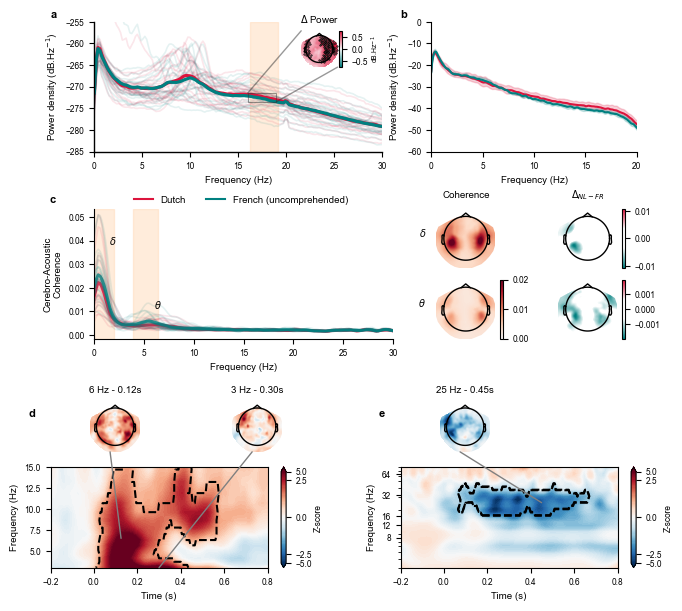

In [57]:
bigfig

# Figure 3

This figures summary results for the TF models on power and phase. We also show the score of those models, as well as a time-resolved version of evaluating TRF models.

Note that this figure consists of several different subfigures which are generated with separate function calls.

In [81]:
import pickle 
from pyeeg.vizu import significance_overlay
from matplotlib import ticker
from matplotlib.patches import FancyBboxPatch
from matplotlib.transforms import blended_transform_factory
from scipy.ndimage import label

# Making a fancy colormap
# from matplotlib.colors import LinearSegmentedColormap
# cmap = plt.get_cmap('viridis')
# colors = cmap(np.linspace(0, 1, 256))
# width = 41
# for i, k in enumerate(range(256//2-width//2, 256//2+width//2)):
#     # print(abs(i-width//2)/(width//2))
#     colors[k] = [*colors[k][:3], abs((i-width//2)/(width//2))**3]
# cmap = LinearSegmentedColormap.from_list('test', colors)
my_palette = sns.color_palette(list(colors.values()))

# parameters and data path for this figure
data_path = os.path.join(source_data_path, 'Figure_3_data/')
itc_files = glob.glob(data_path + '*ITC*')  # both delta and theta
power_files = glob.glob(data_path + '*power*')
bads = ['MLT41', 'MRO52']
info = mne.io.read_info(os.path.join(DATA_PATH, 'processed', 'sub-026', 'meg', 'audioBook-filtered-ICAed-raw.fif'))
info = mne.pick_info(info, mne.pick_types(info, meg=True, ref_meg=False, exclude=bads))
# Loading wordonset-TRF files
trf_itc = {}
for f in ['delta', 'theta']:
    trf_itc[f] = reduce(lambda x,y: x+y, [TRFEstimator.load(i) for i in itc_files if f in i])
    trf_itc[f].coef_ /= float(len(itc_files))
trf_power = {}
for f in ['beta', 'gamma']:
    trf_power[f] = reduce(lambda x,y: x+y, [TRFEstimator.load(i) for i in power_files if f in i])
    trf_power[f].coef_ /= float(len(power_files))

# Loading adjacency matrix for clustering
adj, adj_chans = mne.channels.find_ch_adjacency(info, ch_type='mag')
# Select only my channels
adj_picks = [adj_chans.index(c) for c in info['ch_names']]
adj = adj[adj_picks][:, adj_picks]

trf_times = trf_itc['delta'].times
use_insets = True

    Read 5 compensation matrices
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Reading adjacency matrix for ctf275.


In [82]:
def plot_and_show_clusters(times, cluster_stats, ax=None, color='teal'):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    tobs, clusters, pvals, _ = cluster_stats
    print(f"Smallest p-value for all clusters: {min(pvals)}")
    ax.plot(times, tobs, 'k', lw=1, alpha=0.15, zorder=0);
    signi = np.ones_like(tobs) * np.nan
    mask_chan = None
    for p,cl in zip(pvals,clusters):
        if p < 0.05:
            samp, chan = cl
            chans = np.unique(chan)
            tmin, tmax = times[min(samp)], times[max(samp)]
            signi[cl] = tobs[cl]
            print(f"Time span {tmin} to {tmax} s, {len(chans)} channels")
            ax.plot(times, tobs[:, chans].mean(1), color, lw=2.5, zorder=2)
            ax.fill_between(times, tobs[:, chans].mean(1) - tobs[:, chans].std(1),
                            tobs[:, chans].mean(1) + tobs[:, chans].std(1),
                            color=color, alpha=0.3, zorder=1, edgecolor='none')
            # Just take the time segment where we have at least 12 channels currently significant
            imin, imax = np.nonzero((~np.isnan(signi)).sum(1)>12)[0][[0, -1]]
            tmin, tmax = times[imin], times[imax]
            ax.axvspan(tmin, tmax, alpha=0.2, color='gold', zorder=-1)
            mask_chan = reduce(np.logical_or, (~np.isnan(signi[(~np.isnan(signi)).sum(1) > 18, :])))
    # plt.plot(trf_power['gamma'].times, signi, 'r', lw=1, alpha=0.6);
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('t-statistics')
    return tmin, tmax, mask_chan

def show_wave(times, itc_data, plot_data, fband='delta', ax=None, cmap='viridis', colorbar=True):
    if ax is None:
        _, axr = plt.subplots(1, 2)
    else:
        if isinstance(ax, plt.Axes):
            axr = [ax]
            axinset = ax.inset_axes([0.7, 0.5, 0.5, 0.5])
            axr.append(axinset)
        else:
            assert len(ax)==2, "ax must be a 2-tuple or an Axes object."
            axr = ax

    cmap = plt.get_cmap(cmap)
    mean_peak_time = np.zeros((itc_data.shape[-1],))
    for ch in range(itc_data.shape[-1]):

        peak_time = times[np.argmax(itc_data[:, ch])]
        peak_val = plot_data[np.argmax(itc_data[:, ch]), ch]
        if (-0.05<peak_time<0.6) and (peak_val > (0.0015 if fband=='theta' else 0.006)):
            color = cmap((peak_time-0.05)/0.15) if fband=='theta' else cmap((peak_time-0.01)/0.5)
            # axr[0].plot(trf_itc[fband].times, trf_itc[fband].apply_func(np.abs).coef_.squeeze()[:, ch], color=color, zorder=int(1e3*peak_time))
            axr[0].plot(peak_time, peak_val, 'o', color=color, markersize=2.5)
            mean_peak_time[ch] = peak_time
    vmin = min(mean_peak_time[mean_peak_time!=0.0])
    mean_peak_time[mean_peak_time==0.0] = ((0.5 if fband=='delta' else 0.2)+vmin)/2.#np.median(mean_peak_time[mean_peak_time!=0.0])
    im = topomap(mean_peak_time, info, cmap=cmap, contours=0, vlim=(vmin, 0.2 if fband=='theta' else 0.5), sphere=0.14, ax=axr[1], sensors=False, colorbar=colorbar);
    axes = im.get_axes()
    if colorbar:
        cb = [a for a in axes if 'colorbar' in a.get_label()][0]
        cb.set_ylabel('Peak time (s)', rotation=-90, labelpad=5)
        axr[1].set_title(f'$\\{fband}$ travelling\nwave')


def load_timed_data(fband='delta', model='nl', use_ica=True, itc=False, pac=False, causal=False, with_acoustic=True, grouping='PerCategory',
                    nfeat_control='constant', use_pct=True):
    """
    Load the timed data for a given frequency band and model
    """
    bandname = fband
    with_envelope = with_acoustic
    feature_category = grouping #'PerCategory' # or SingleFeature or PerCategory or Incremental
    feat_mode = nfeat_control # None for old version 'constant' or 'incremental' (do we use all features all the time nullifying the one not in the featset or do we use only the ones in the featset)
    files = [f for f in glob.glob(os.path.join(source_data_path, 'Figure_3_data', '/Timed_TRF' + \
                                (f'-{feature_category}' if feature_category is not None else '') + '*' + \
                                ('acoustic*' if with_envelope else '')))\
                                    if ((bandname in f) and ((re.search('acoustic', f) is not None) == with_envelope))] # for the new versions (larger time window and possibly causal non-causal filters)
    files = [f for f in files if (model in f)]
    if feat_mode is None:
        files = [f for f in files if ('constant' not in f) and ('incremental' not in f)]
    else:
        files = [f for f in files if feat_mode in f]
    def selector(f):
        if pac: return 'pac' in f
        return ('itc' in f)==itc and ('ica' in f)==use_ica and ('pac' not in f)
    files = list(filter(selector, files))
    files = [f for f in files if ('causal' in f) == causal]
    # print(f"Found {len(files)} files.")
    if len(files) == 0:
        raise ValueError("No files found")

    all_dfs = []
    for cur_file in files:
        idx_sub = cur_file.find('sub-')
        subj = cur_file[idx_sub:idx_sub+7]
        if subj in ['sub-002', 'sub-017']: continue
        with open(cur_file, 'rb') as f:
            timed_score = pickle.load(f)

        df = pd.DataFrame(timed_score)
        if itc or pac: df = df.abs()
        base_model = 'acoustic' if with_envelope else 'wordonsets'
        # base_model = 'acoustic_wordonsets' if with_envelope else 'wordonsets'
        for c in df.columns.unique():
            if c != base_model:
                df[c] -= df[base_model]
                if use_pct:
                    if itc or pac:
                        df[c] /= df[base_model].abs().median()
                    else:
                        df[c] /= df[base_model].median()
                    df[c] *= 100
        if with_envelope: df.drop(columns=base_model, inplace=True)
        df.index.set_names('lags', inplace=True)
        df = df.reset_index().melt(id_vars='lags', var_name='features', value_name='score')
        df['subject'] = subj
        all_dfs.append(df)
    df = pd.concat(all_dfs)
    avg_df = df.groupby(['lags', 'features']).mean(numeric_only=True).reset_index()
    data = avg_df.pivot(index='lags', columns='features', values='score').to_numpy().T
    return df, data

def make_figure_timed_score(fig=None, params={}, legend_on_top=False, use_pct=True, is_poster=False, fband_to_show=['delta', 'theta', 'alpha', 'beta', 'gamma']):
    def plot_sigini_bars(stats, currentax, lags, ypos=0.9, **boxargs):
            transform = blended_transform_factory(currentax.transData, currentax.transAxes)
            pvals = stats.pvalue < 0.05
            # Find connected components
            labels, n = label(pvals)
            # plot fancy boxes spanning the significant regions
            for i in range(1, n+1):
                idx = np.where(labels==i)
                l, r = lags[idx[0][0]], lags[idx[0][-1]]
                if stats.statistic[idx].mean() > 0:
                    patch = FancyBboxPatch((l, ypos), max(0.01, r-l), 0.001, boxstyle="round,pad=0.025", edgecolor='none', transform=transform, **boxargs)
                    currentax.add_patch(patch)
    if fig is None:
        fig, axes = plt.subplots(1, len(fband_to_show), layout='tight', figsize=(7.2, 2.), sharey=True, squeeze=False)
        axes = np.squeeze(axes, axis=0)
        f = fig
    else:
        if len(fig.axes) == 0:
            axes = fig.subplots(1, len(fband_to_show), layout='tight', sharey=True, squeeze=False)
            axes = np.squeeze(axes, axis=0)
        else:
            axes = fig.axes
        f = fig

    show_legend = True
    for k, (fband, ax) in enumerate(zip(fband_to_show, axes)):
        # load data
        try:
            use_itc = (fband in ['delta', 'theta']) and params['itc']
            df, data = load_timed_data(fband=fband, model='nl', use_pct=use_pct, **({'itc':use_itc} | params))
            alpha_crit = 0.05/len(df.lags.unique())/3 # divided by number of lags (bonferonni)
        except ValueError as e:
            print(f'{fband}: ' + str(e))
            show_legend = False
            continue
        wo = data[0]
        #data[-1] -= (data[1] + data[2])/2
        data[1:] -= wo
        feature_category = params.get('grouping', 'PerCategory')
        with_envelope = params.get('with_acoustic', True)
        if feature_category is None or feature_category == 'PerCategory':
            data[-1] -= np.maximum(data[1],data[2])
            wo, synt, stats, all_feats = data
        elif feature_category == 'Incremental':
            data[-1] -= np.maximum(data[2],data[3])
            wo, _, stats, _, all_feats = data
        elif feature_category == 'SingleFeature':
            # wo, synt, stats, all_feats = data
            # wo, surp, entr, depth, close = data
            # surp, entr, depth, close = data
            pass
        
        # Stats between groups
        if feature_category != 'SingleFeature':
            wo_data = df[df.features==('acoustic_' if with_envelope else '') + 'wordonsets'].pivot(index=['lags'], columns='subject', values='score').to_numpy()
            stats_data = df[df.features==('acoustic_' if with_envelope else '') + 'wordonsets_surprisal_entropy'].pivot(index=['lags'], columns='subject', values='score').to_numpy()
            synt_data = df[df.features==('acoustic_' if with_envelope else '') + 'wordonsets_depth_close'].pivot(index=['lags'], columns='subject', values='score').to_numpy()
            all_data = df[df.features==('acoustic_' if with_envelope else '') + 'wordonsets_surprisal_entropy_depth_close'].pivot(index=['lags'], columns='subject', values='score').to_numpy()

            # STATS
            ax.plot(df.lags.unique(),  np.where(ttest_1samp(wo_data, popmean=0, axis=1).pvalue > alpha_crit, np.nan, wo), ls='', marker='o', markersize=4)
            plot_sigini_bars(ttest_1samp(wo_data, popmean=0, axis=1), ax, df.lags.unique(), 0.95, facecolor='C0')
            teststats = ttest_1samp(synt_data - wo_data, popmean=0, axis=1) # syntax
            plot_sigini_bars(teststats, ax, df.lags.unique(), 0.9, facecolor='C1')
            ax.plot(df.lags.unique(), np.where((teststats.pvalue <= alpha_crit) & (teststats.statistic>0), np.maximum(wo, 0.0)+synt, np.nan), ls='', marker='o', markersize=4)
            teststats = ttest_1samp(stats_data - wo_data, popmean=0, axis=1) # stats
            plot_sigini_bars(teststats, ax, df.lags.unique(), 0.85, facecolor='C2')
            ax.plot(df.lags.unique(), np.where((teststats.pvalue <= alpha_crit) & (teststats.statistic>0), np.maximum(wo, 0.0)+stats+synt, np.nan), ls='', marker='o', markersize=4)
            teststats = ttest_1samp(all_data - np.maximum(synt_data, stats_data), popmean=0, axis=1) # all
            plot_sigini_bars(teststats, ax, df.lags.unique(), 0.8, facecolor='C3')
            ax.plot(df.lags.unique(), np.where((teststats.pvalue <= alpha_crit) & (teststats.statistic>0), np.maximum(wo, 0.0)+stats+synt+all_feats, np.nan), ls='', marker='o', markersize=4)

        # Stack plot
        p = ax.stackplot(df.lags.unique(), np.where(data>0.0, data, 0.0), alpha=0.8)
        # Readjust height if NOT sharing axes:
        if len(ax.get_shared_y_axes().get_siblings(ax)) <= 1:
            ax.set_ylim(0, ax.get_ylim()[1]*1.55)
            
        # Grid lines
        ax.set_xticks((df.lags.unique()+0.05)[::3], [f'{l:.1f}' for l in (df.lags.unique()+0.05)[::3]])
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
        ax.grid(True, 'both', axis='x', zorder=-1, color=(0.8,)*3)
        ax.set_axisbelow(True)
        ax.set_xmargin(0)
        # comsmetics
        sns.despine(ax=ax)
        ax.set_xlabel('Lag (s)')
        ax.set_ylabel('Relative score\n improvement (%)')
        if k>0:
            ax.set_ylabel('')
    if show_legend:
        f.legend(p, [' '.join(map(str.capitalize, [f for f in fea.split('_') if f!='acoustic'])) for fea in df.features.unique()],
                    bbox_to_anchor=(0.0, 1.1 if legend_on_top else 0.01), loc='upper left',
                    ncol=4, frameon=False, fontsize=6 if not is_poster else 14)
    return f

def make_figure_score(fig=None, fband_to_show=['delta', 'theta', 'alpha', 'beta', 'gamma'], show_dots=False):

    if fig is None:
        fig, ax = plt.subplots(2, len(fband_to_show), figsize=(7.1, 2.85), sharey='row', gridspec_kw={'height_ratios':[2, 1]})
    else:
        if len(fig.axes) == 0:
            ax = fig.subplots(2, len(fband_to_show), sharey='row', gridspec_kw={'height_ratios':[2, 1]})
        else:
            ax = fig.axes
        f = fig
    for fband, aax, axin in zip(fband_to_show, ax[0, :], ax[1, :]):
        df = pd.read_csv(os.path.join(source_data_path, 'Figure_3_data', f'{fband}_TRF_scores_nullified_and_additive.csv'))
        sns.barplot(df.loc[df.features!='Base'], x='features', y='score_rel',
                    palette=[my_palette[1], my_palette[2], my_palette[-1], np.asarray(sns.desaturate(my_palette[-1], 0.5))+0.25],
                    legend=fband=='delta', hue='features', hue_order=['Rule-based', 'Statistical', 'Joint', 'Additive'], errorbar='se', ax=aax, estimator='mean')
        if show_dots:
            # Better:
            sns.stripplot(data=df[df.features!='Base'], x='features', y='score_rel', hue='features',
                        palette=[my_palette[1], my_palette[2], my_palette[-1], np.asarray(sns.desaturate(my_palette[-1], 0.5))+0.25],
                        dodge=False, ax=aax, edgecolor='k', linewidth=0.5, size=3, alpha=0.7, zorder=1, jitter=0.2)
        
        pval = ttest_1samp(df[df.features=='Rule-based'].score_rel - df[df.features=='Statistical'].score_rel.values, 0).pvalue
        significance_overlay(f"$p=${pval:0.3f}" if (0.05<pval<0.2) else ('**' if pval<0.05 else '$n.s.$'), [0, 1], fontsize=7, barh=0.0, dh=0, maxasterix=3, ax=aax,
                            height=np.mean(df.loc[df.features=='Statistical'].score_rel)*1.3)
        pval = ttest_1samp(df[df.features=='Rule-based'].score_rel - df[df.features=='Joint'].score_rel.values, 0).pvalue
        significance_overlay(pval, [0, 2], fontsize=8, barh=0.0, dh=0, maxasterix=3, ax=aax,
                            height=np.mean(df.loc[df.features=='Joint'].score_rel)*1.1)
        pval = ttest_1samp(df[df.features=='Additive'].score_rel - df[df.features=='Joint'].score_rel.values, 0).pvalue
        significance_overlay(pval, [2, 3], fontsize=8, barh=0.0, dh=0, maxasterix=3, ax=aax,
                            height=np.mean(df.loc[df.features=='Joint'].score_rel)*1.2)

        if aax is ax[0, 0]:
            aax.set_ylabel('$\\Delta r$ Score increment\n (vs. Base model)')
        else:
            aax.set_ylabel('')
        aax.set_xlabel('')
        aax.set_title(f'$\\{fband}$', pad=-3)
        aax.axhline(0, color='k', lw=1.5)
        sns.despine(ax=aax, left=fband!='delta', bottom=True)
        aax.tick_params(bottom=False, labelbottom=False)

        sns.boxplot(df, x='features', y='score',
                        palette=[my_palette[0], my_palette[1], my_palette[2], my_palette[-1], np.asarray(sns.desaturate(my_palette[-1], 0.5))+0.25],
                        legend=False, hue='features', hue_order=['Base', 'Rule-based', 'Statistical', 'Joint', 'Additive'],
                        order=['Base', 'Rule-based', 'Statistical', 'Joint', 'Additive'], ax=axin, showfliers=False, width=0.5)
        sns.despine(ax=axin, left=fband!='delta', bottom=True)
        axin.set_ylim(0, 0.15)
        axin.set_xlabel('')
        axin.set_ylabel('')
        axin.set_xticks([])
        if fband != 'delta':
            # remove yticks completely
            aax.tick_params(left=False, labelleft=False)
            axin.tick_params(left=False, labelleft=False)
        else:
            handles, labels = aax.get_legend_handles_labels()
            handle_dict = dict(zip(labels, handles))
            selected_handles = [handle_dict[label] for label in ['Rule-based', 'Statistical', 'Joint', 'Additive']]
            fig.legend(handles=selected_handles, labels=['Rule-based', 'Statistical', 'Joint', 'Additive'],
                        loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=4, frameon=False)
            aax.legend().remove()
            axin.set_ylabel('Score  $r$')

    return fig, ax

### Generating figures

In [83]:
params_timed = {'use_ica':True,
                'itc':False, 'pac':False,
                'causal':True,
                'with_acoustic':True,
                'grouping':'PerCategory',
                'nfeat_control':'constant'}
print(f"""
Loading data for:
    - ICA-ed data: {params_timed['use_ica']}
    - ITC? {params_timed['itc']}
    - PAC? {params_timed['pac']}
    - Using causal filter?: {params_timed['causal']}
    - With acoustic envelope: {params_timed['with_acoustic']}
    - Feature grouping: {params_timed['grouping']}
    - Incremental null models or constant number of features: {params_timed['nfeat_control']}
    """)

with plt.style.context([{'savefig.pad_inches':0.} | paper_fontsizes]):
    bigfig = plt.figure(figsize=(7.2, 6.), layout='constrained')
    figs = bigfig.subfigures(4, 1, height_ratios=[2, 1, 1, 1.75], hspace=0.1)

    ax = figs[0].subplots(2, 4, gridspec_kw={'hspace':0.3, 'wspace':0.8})
    gs = ax[0, 0].get_gridspec()
    ax_bottom = ax[1,:]
    ax = ax[0,:]
    for k, (fband, t) in enumerate(chain.from_iterable([tt.items() for tt in [trf_itc, trf_power]])):
        # Cluster analysis:
        lowfreq = fband in ['delta', 'theta']
        if lowfreq:
            files = itc_files
        else:
            files = power_files
        baseline_removal = lambda trf: trf.coef_.squeeze() - trf.coef_.squeeze()[0:np.searchsorted(trf.times, -0.01)].mean(0)
        tobs, clusters, pvals, _ = mne.stats.spatio_temporal_cluster_1samp_test(np.asarray([baseline_removal(TRFEstimator.load(i).apply_func(np.abs if lowfreq else (lambda x: x))) for i in files if fband in i]),
                                                                                tail=int(lowfreq), adjacency=adj, n_jobs=8, threshold=3.26 if lowfreq else 2.071) # threhold are for 0.001  (one tail) and 0.05 (two tail)

        t1, t2, _ = plot_and_show_clusters(trf_times, (t.apply_func(np.abs).coef_.squeeze() if lowfreq else tobs, clusters, pvals, None), ax=ax[k], color='crimson' if lowfreq else 'teal')
        ax[k].set_title(f'$\\{fband}$')
        # Topomaps
        # Getting the boundaries of cluster
        s1, s2 = tuple(map(lambda t: np.searchsorted(trf_times, t), (t1, t2)))
        if lowfreq:
            show_wave(trf_times, t.apply_func(np.abs).coef_.squeeze(), t.apply_func(np.abs).coef_.squeeze(), fband=fband, ax=ax[k] if use_insets else [ax[k], ax_wave[k]], cmap=cmap, colorbar=not use_insets)
            if use_insets and fband=='delta':
                ax[k].set_ylim(-0.001, 0.02)
                ax[k].set_ylabel('ITC (a.u.)')
            topomap(t.apply_func(np.abs).coef_[s1:s2].mean(0).squeeze(), info, ax=ax_bottom[k], sphere=0.13, sensors=False, contours=0)
        else:
            topomap(t.coef_[s1:s2].mean(0).squeeze(), info, ax=ax_bottom[k], sphere=0.13, sensors=False, contours=0)
            ax[k].set_ylabel('T-statistics')
        
        if k%2==1: ax[k].set_ylabel('')
        sns.despine(ax=ax[k])
    figs[0].suptitle('Word-evoked phase and power modualtion')

    # --------- Score in source space ----------
    ax1 = figs[2].subplots(1, 4)
    for ax ,fband in zip(ax1, ['delta', 'theta', 'beta', 'gamma']):
        try:
            # load_and_plot_source_data(fband=fband, ax=ax)
            load_and_plot_source_data_V2(fband=fband, ax=ax, fdr=True, use_r2=fband=='delta')
        except Exception as e:
            print(e)
            # raise e
    figs[2].suptitle('Score in source space')

    with plt.rc_context({'axes.prop_cycle': plt.cycler(color=my_palette)}):
        # --------- Time-resolved TRF score ----------
        ax2 = figs[1].subplots(1, 4)
        make_figure_timed_score(figs[1], params_timed, legend_on_top=True, fband_to_show=['delta', 'theta', 'beta', 'gamma'])
        figs[1].suptitle('Time-resolved Reconstruction accuracy')
        
        # --------- Full TRF score ----------
        make_figure_score(figs[3], fband_to_show=['delta', 'theta', 'beta', 'gamma'])
        figs[3].suptitle('Reconstruction accuracy')

    bigfig


Loading data for:
    - ICA-ed data: True
    - ITC? False
    - PAC? False
    - Using causal filter?: True
    - With acoustic envelope: True
    - Feature grouping: PerCategory
    - Incremental null models or constant number of features: constant
    
stat_fun(H1): min=-11.195553929802973 max=14.454151437193655
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Smallest p-value for all clusters: 0.0009765625
Time span -0.12 to 0.58 s, 267 channels
stat_fun(H1): min=-4.3890887834591235 max=8.26692898999881
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Smallest p-value for all clusters: 0.0009765625
Time span -0.02 to 0.34 s, 222 channels
stat_fun(H1): min=-8.43205055143358 max=3.8901085605965284
Running initial clustering …
Found 35 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Smallest p-value for all clusters: 0.0009765625
Time span -0.06 to 0.58 s, 264 channels
stat_fun(H1): min=-5.167955474811269 max=4.322177842566128
Running initial clustering …
Found 229 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Smallest p-value for all clusters: 0.001953125
Time span 0.14 to 0.56 s, 99 channels
name 'load_and_plot_source_data_V2' is not defined
name 'load_and_plot_source_data_V2' is not defined
name 'load_and_plot_source_data_V2' is not defined
name 'load_and_plot_source_data_V2' is not defined
delta: No files found
theta: No files found
beta: No files found
gamma: No files found


NameError: name 'fs' is not defined

c:\Users\hugwei\.conda\envs\hugo2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


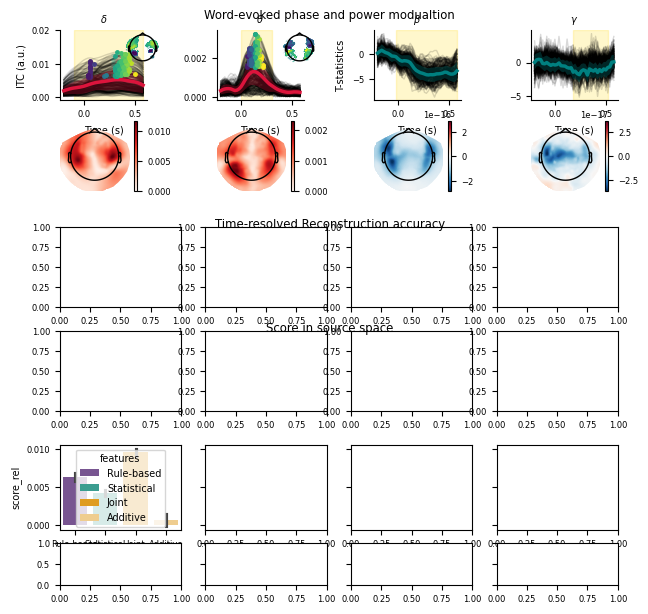

In [ ]:
bigfig

# Figure 4

To be added...

# Figure 5

To be added...